In [1]:
import numpy as np
import pandas as pd
import math

import pickle

import matplotlib.pyplot as plt

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(-1, '/mnt/x/Computation/Utilities')

import ocu_seaside.ocu_basics as se
import ocu_seaside.ocu_visuals as viz
import ocu_chisel as chis
import ocu_binmeths as bm


import os
os.chdir('/mnt/x/Computation/Projects/CS3-YY1/data/R2')

In [3]:
tomain = '../../../../'

hg38folder = tomain + 'Essentials/hg38/'
hg38_id, hg38_sizes = se.PickleLoad(hg38folder + 'hg38_id_sizes')
hg38_basic_id, hg38_basic_sizes = se.PickleLoad(hg38folder + 'hg38_basic_id_sizes')
hg38_auto_ids = hg38_basic_id[:-3]


encodefolder = se.NewFolder(tomain + 'data/!ENCODE')

peaksfolder = se.NewFolder(encodefolder + 'peaks')
curfolder = se.NewFolder(encodefolder + 'currents')
procfolder = se.NewFolder(curfolder + 'processed')

data_source = pd.read_excel(encodefolder + 'Dataset_Identifiers.xlsx')
yy1, histones = [data_source[data_source['target_type'] == x]['target'].unique() 
                    for x in ['yy1', 'histone']]

CTreso = 50

savefolder = se.NewFolder('yy1_data')
divset = ['Train', 'Stop.', ' Eval', 'Test'] 

In [4]:
print(histones)

['H3K4me3' 'H3K27ac' 'H3K27me3' 'H3K4me1' 'H3K36me3' 'H3K9me3' 'H3K9ac'
 'H3K4me2' 'H4K20me1' 'H2AFZ' 'H3K79me2']


In [5]:
yy1_size = 50
seq_size = 500 
his_size = 2000 ########################### CHANGED

trans = 150 #Maximum trans is 200 on each side 

yy1_size_big, seq_size_big, his_size_big = [c + (trans*2) for c in [yy1_size, seq_size, his_size]]

print(yy1_size_big, seq_size_big, his_size_big)

350 800 2300


In [6]:
num_trans_wins = 3

uniquesites = 20000
totalsites = uniquesites * num_trans_wins

# Over Peaks

In [37]:
hg38_basic_BLC_LR50 = se.PickleLoad(hg38folder + 'hg38_basic_BLC_LR50') #0s are bad
BLC_inv = chis.BinCurrentInverter(hg38_basic_BLC_LR50) #0s are good

In [38]:
yy1_peaks = chis.Bed2Markers(encodefolder + 'peaks/yy1/yy1_summits.bed', addcols = [4])

num_peaks_top = 1000
yy1_peaks_top = yy1_peaks.sort_values('add4', ascending = False).iloc[:num_peaks_top].reset_index(drop = True)
yy1_peaks_top

,subseq,loc,strand,size,add4
0,chr2,231662510,0,1,329.027
1,chr19,10315982,0,1,329.027
2,chr8,119873763,0,1,329.027
3,chrX,152941677,0,1,329.027
4,chr20,2840666,0,1,329.027
...,...,...,...,...,...
995,chr18,56651177,0,1,263.190
996,chr12,109996433,0,1,263.190
997,chr10,74176527,0,1,263.190
998,chr10,84139324,0,1,263.190


In [39]:
yy1_peaks_filt = chis.MarkersFilter(yy1_peaks_top, BLC_inv, hg38_basic_id, select_BS_ids = None, 
                              reso = CTreso, exact = False, 
                              Msizes = [1000], threshold = 0, 
                              threshmode = np.sum, threshsign = np.equal)

yy1_peaks_filt2 = chis.Markers4Packs(yy1_peaks_filt, select_BS_ids = hg38_auto_ids, opposite = True, 
                                 ends = 5000, BS_sizes = hg38_basic_sizes, BS_ids = hg38_basic_id)
#Filter out the ends and then double 

yy1_peaks_filt2

,subseq,loc,strand,size,add4
0,chr1,1231996,0,1,293.518
1,chr1,1231996,1,1,293.518
2,chr1,1273843,0,1,324.298
3,chr1,1273843,1,1,324.298
4,chr1,1399312,0,1,284.448
...,...,...,...,...,...
1891,chr9,137130035,1,1,278.266
1892,chr9,137200707,0,1,298.396
1893,chr9,137200707,1,1,298.396
1894,chr9,137205650,0,1,284.984


<Axes: xlabel='Nucleotides (nts)', ylabel='YY1 Score'>

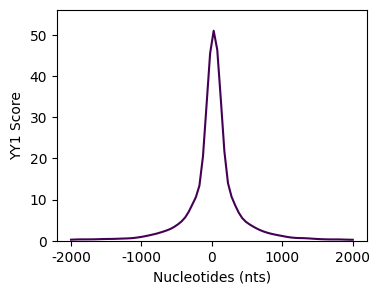

In [41]:
yy1_mode = se.PickleLoad(procfolder + 'YY1_mode')

yy1_overpeaks = chis.SigCurrent2Pack(yy1_mode, yy1_peaks_filt2, hg38_auto_ids, select_BS_ids = None,
                                Vsize = 4000, reso = CTreso, newreso = None, resomode = np.mean, areas = None, exact = True, 
                                stranded = True, dtype = np.float32)

yy1_squished = np.mean(yy1_overpeaks, axis = 0)

yy1_xtl = [str(x) for x in np.linspace(-2000, 2000, 5, dtype = int)]

viz.LinePlot(yy1_squished.reshape(-1), bounds = (0, np.max(yy1_squished) * 1.1),  
         xlabel = 'Nucleotides (nts)', ylabel = 'YY1 Score', suptitle = None, #'yy1',
         xticklabel = yy1_xtl, 
         figsize = (4,3))

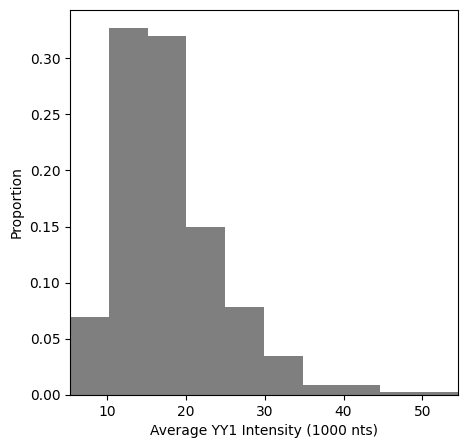

In [11]:
yy1_overpeaks_2 = chis.SigCurrent2Pack(yy1_mode, yy1_peaks_filt2, hg38_auto_ids, select_BS_ids = None,
                                Vsize = 1000, reso = CTreso, newreso = None, resomode = np.mean, areas = None, exact = True, 
                                stranded = True, dtype = np.float32)

meanx = np.mean(yy1_overpeaks_2, axis = 1).reshape(-1)

hp_args = {'bins': 10, 'density': False,'proportion': True, 
           'xlabel': 'Average YY1 Intensity (1000 nts)', 'ylabel': 'Proportion', 'color': 'black'}


viz.HistPlot(meanx, **hp_args)

In [12]:
his_mode = se.PickleLoad(procfolder + 'his_mode')

Vsize = 10000

his_overpeaks = chis.SigCurrent2Pack(his_mode, yy1_peaks_filt2, hg38_auto_ids, select_BS_ids = None,
                                Vsize = Vsize, reso = CTreso, newreso = None, resomode = np.mean, areas = None, exact = True, 
                                stranded = True, dtype = np.float32)

In [13]:
his_overpeaks.shape

(1896, 200, 11)

In [14]:
his_squished = np.mean(his_overpeaks, axis = 0)

his_xtl = [str(x) for x in np.linspace(-Vsize // 2, Vsize // 2, 5, dtype = int)]

array([[<Axes: title={'center': 'H3K4me3'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>,
        <Axes: title={'center': 'H3K27ac'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>,
        <Axes: title={'center': 'H3K27me3'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>,
        <Axes: title={'center': 'H3K4me1'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>],
       [<Axes: title={'center': 'H3K36me3'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>,
        <Axes: title={'center': 'H3K9me3'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>,
        <Axes: title={'center': 'H3K9ac'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>,
        <Axes: title={'center': 'H3K4me2'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>],
       [<Axes: title={'center': 'H4K20me1'}, xlabel='Nucleotide', ylabel='Intensity (Weighted Average)'>,
        <Axes: title={'center': 'H2AFZ'}, xlabel='N

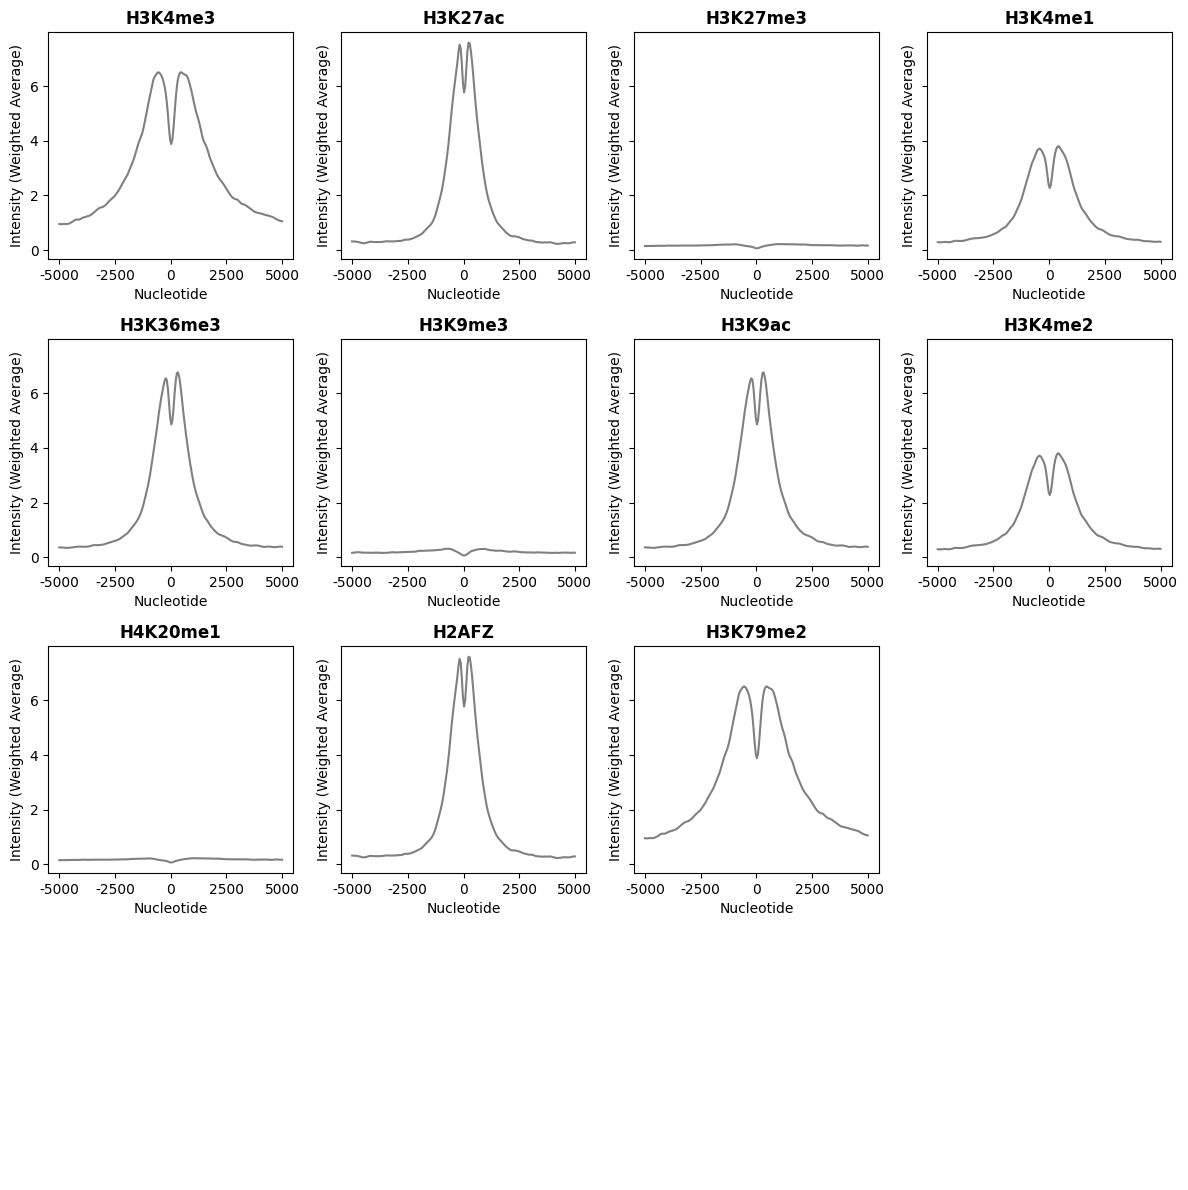

In [15]:
lp_args = {'color': 'Gray', 
           'xlabel': 'Nucleotide', 
           'ylabel': 'Intensity (Weighted Average)', 
           'xticklabel': his_xtl}


viz.MultiPlot(his_squished.T, multi=True, 
          plt_mode = [viz.LinePlot, lp_args], 
          indiv_args = {'suptitle': histones},

          customgrid=(4,4), figsize = (12,12), 
          sharey = True, sharex =  False)

# Flags

In [ ]:
# hg38_basic_BLC_LR50 = se.PickleLoad(hg38folder + 'hg38_basic_BLC_LR50') #0s are bad

# #---------------------------------------------

# yy1_inps_mean = se.PickleLoad(procfolder + 'Input_BGG_mean')

# his_inps_mean = se.PickleLoad(procfolder + 'Input_AKY_mean')

# yy1_inps_gt = chis.CurrentThresholder(yy1_inps_mean, threshold = 0.5, ##################
#                                              threshsign = np.greater, binary = True)

# his_inps_gt = chis.CurrentThresholder(his_inps_mean, threshold = 0.5, ##################
#                                             threshsign = np.greater, binary = True)

# inps_mean_gt = [x*y for x, y in zip(yy1_inps_gt, his_inps_gt)]

# #---------------------------------------------

# comb_bad = chis.CurrentModifier(hg38_basic_BLC_LR50, inps_mean_gt, 
#                                 mode = np.multiply) # now we have all bads. 

# comb_bad_exp = chis.CurrentZeroExpander(comb_bad, reso = CTreso, 
#                                              exp_size = his_size_big + CTreso)

In [ ]:
# yy1_betap = se.PickleLoad(procfolder + 'YY1_mode')

# yy1_betap_p1 = [z+1 for z in yy1_betap]
# yy1_betap_p1_filt = chis.CurrentModifier(yy1_betap_p1, comb_bad_exp, 
#                                            mode = np.multiply)

# peaksize = 2000
# flag_window = (peaksize // 2)   #to get no overlap of peaksize

# yy1_flags = chis.CurrentFlagger(yy1_betap_p1_filt, reso = CTreso,
#                               window = flag_window, #dont want windows of scores to overlap 
#                               stride = 1, flagmode = np.argmax)

# se.PickleDump(yy1_flags, savefolder + 'yy1_flags')

In [ ]:
# yy1_flags = se.PickleLoad(savefolder + 'yy1_flags')

# yy1_flags_sites = chis.SigCurrent2Markers(yy1_flags, select_BS_ids = hg38_auto_ids, 
#                                         reso = CTreso, select = None, select_mode = None)

# yy1_flags_sites['val'] = yy1_flags_sites['val'] - 1 #removing the added pseudo val. 

# se.PickleDump(yy1_flags_sites, savefolder + 'yy1_flags_sites')

# yy1_flags_sites = se.PickleLoad(savefolder + 'yy1_flags_sites')
# yy1_flags_sites

,subseq,loc,strand,size,val
0,chr1,1094350,0,1,0.013116
1,chr1,1095350,0,1,0.000000
2,chr1,1100050,0,1,0.105914
3,chr1,1391850,0,1,0.039723
4,chr1,1400500,0,1,3.483717
...,...,...,...,...,...
113535,chr9,136787800,0,1,1.310421
113536,chr9,137088550,0,1,0.082967
113537,chr9,137490700,0,1,0.704464
113538,chr9,137511750,0,1,0.363776


/mnt/x/Computation/Utilities/ocu_chisel.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Markers.subseq =pd.Categorical(Markers.subseq,categories=ids)


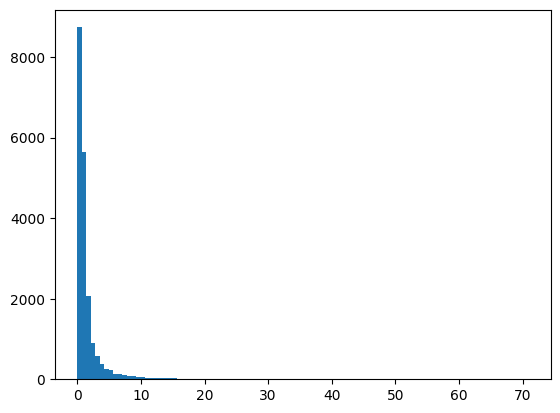

In [ ]:
# yy1_flags_sites = se.PickleLoad(savefolder + 'yy1_flags_sites')
# yy1_flags_vals = yy1_flags_sites['val'].to_numpy()

# yy1_flags_vals_bind = bm.HistBinning(yy1_flags_vals, bins = 10000)
# selo = bm.Harpoon(yy1_flags_vals_bind, select = uniquesites)
# selo_vals = [x[selo] for x in [yy1_flags_vals, yy1_flags_vals_bind]]
# plt.hist(selo_vals[0], bins = 100)

# yy1_sites_selo = chis.SortMarkers(yy1_flags_sites.iloc[selo], hg38_auto_ids)
# se.PickleDump(yy1_sites_selo, savefolder + 'yy1_sites_selo')

In [34]:
fin_bins_fake = 10

yy1_sites_selo = se.PickleLoad(savefolder + 'yy1_sites_selo')

selo_vals = yy1_sites_selo['val'].to_numpy()
selo_vals_scaled = selo_vals / np.max(selo_vals)

flags_vals_uni = bm.HistUni(selo_vals_scaled, bins = fin_bins_fake)
flags_vals_bind = bm.Binner(selo_vals_scaled, uni = flags_vals_uni)

bncs_tots = bm.BinCount(flags_vals_bind, uni = np.arange(fin_bins_fake), prop = False)
bncs_tots_props = bm.BinCount(flags_vals_bind, uni = np.arange(fin_bins_fake), prop = True)

pdy = pd.DataFrame(columns = ['Bin'], data = np.arange(fin_bins_fake) + 1)

pdy[['Start', 'Stop']] = np.stack(flags_vals_uni)
pdy['Size'] = pdy['Stop'] - pdy['Start']
pdy['Bin'] = np.arange(fin_bins_fake) + 1
pdy = pdy.set_index(['Bin'])

pdy['Num.'] = bncs_tots
pdy['Prop.'] = bncs_tots_props

pdy = pdy.style.format(precision=4).background_gradient(cmap = 'Grays', axis = 0, subset = ['Prop.', 'Num.'])
pdy

,Start,Stop,Size,Num.,Prop.
Bin,,,,,
1,0.0000,0.1000,0.1000,19050,0.9525
2,0.1000,0.2000,0.1000,550,0.0275
3,0.2000,0.3000,0.1000,154,0.0077
4,0.3000,0.4000,0.1000,87,0.0043
5,0.4000,0.5000,0.1000,73,0.0037
6,0.5000,0.6000,0.1000,50,0.0025
7,0.6000,0.7000,0.1000,19,0.0009
8,0.7000,0.8000,0.1000,11,0.0006
9,0.8000,0.9000,0.1000,3,0.0001


In [35]:
minobs = 50
maxrange = 0.45 
binmode = [se.tanh, {}]
binrevmode = [se.revtanh, {}]


# fin_bins = bm.FindNumBins(selo_vals_scaled, 
                
#                 mode = binmode, mode_rev = binrevmode, 
#                 maxrange = maxrange, minobs = minobs, 

#                 minbins = 5, maxbins = 300,
#                 start = 1, increm = 0.001, 
#                 mima = None, lowerbound = None, upperbound = None)

fin_bins = 10

se.PickleDump(fin_bins, savefolder +'fin_bins')

In [ ]:
fin_bins = se.PickleLoad(savefolder + 'fin_bins')

fin_bin_args = {'mode': binmode, 'mode_rev': binrevmode,
                'bins': fin_bins, 'mima': None,  
                'lowerbound': None, 'upperbound': None}


fin_bins_sf = bm.FindScaleFactor(selo_vals_scaled, 
                                 minobs = minobs, maxrange = maxrange,
                                start = 1, increm = 0.001,
                                    **fin_bin_args)

print(fin_bins_sf)

fin_bins_brs = bm.ObjUni(selo_vals_scaled, scalefactor = fin_bins_sf,
                            **fin_bin_args)

obs_bind = bm.Binner(selo_vals_scaled, uni = fin_bins_brs)
print(bm.BinCount(obs_bind, uni = np.arange(fin_bins), multi = False))

se.PickleDump(fin_bins_sf, savefolder + 'fin_bins_sf')
se.PickleDump(fin_bins_brs, savefolder + 'fin_bins_brs')
se.PickleDump(obs_bind, savefolder + 'obs_bind')

2.497
[17320  1471   458   231   163    76    75    74    81    51]


In [77]:
bncs_tots = bm.BinCount(obs_bind, uni = np.arange(fin_bins), prop = False)
bncs_tots_props = bm.BinCount(obs_bind, uni = np.arange(fin_bins), prop = True)

pdy = pd.DataFrame(np.arange(fin_bins), columns=['Bin'])
pdy[['Start', 'Stop']] = np.stack(fin_bins_brs)
pdy['Size'] = pdy['Stop'] - pdy['Start']
pdy = pdy.set_index(['Bin'])
pdy['Num.'] = bncs_tots
pdy['Prop.'] = bncs_tots_props
pdy_style = pdy.style.format(precision=4).background_gradient(cmap = 'Grays', axis = 0, subset = ['Size', 'Num.'])
pdy_style = pdy_style.background_gradient(cmap = 'Grays', axis = 0, subset = 'Prop.')
display(pdy_style)

,Start,Stop,Size,Num.,Prop.
Bin,,,,,
0,0.0000,0.0396,0.0396,17320,0.8660
1,0.0396,0.0801,0.0404,1471,0.0736
2,0.0801,0.1222,0.0421,458,0.0229
3,0.1222,0.1671,0.0449,231,0.0115
4,0.1671,0.2164,0.0493,163,0.0081
5,0.2164,0.2726,0.0562,76,0.0038
6,0.2726,0.3400,0.0675,75,0.0037
7,0.3400,0.4283,0.0882,74,0.0037
8,0.4283,0.5654,0.1371,81,0.0040


# Packs

## Full Packs

In [78]:
yy1_sites_selo = se.PickleLoad(savefolder + 'yy1_sites_selo')
yy1_sites_selo

,subseq,loc,strand,size,val
0,chr1,1400500,0,1,3.483717
1,chr1,1402150,0,1,2.796826
2,chr1,1780600,0,1,1.323477
3,chr1,1833050,0,1,0.554176
4,chr1,1872550,0,1,0.587067
...,...,...,...,...,...
19995,chr22,39920200,0,1,0.596552
19996,chr22,39948000,0,1,1.513357
19997,chr22,39949750,0,1,1.810988
19998,chr22,39950800,0,1,0.529328


In [79]:
# SEQ

hg38_basic = pickle.load(open(hg38folder + 'hg38_basic' + '.p', 'rb'))


pack_seq_ohe = chis.SeqCurrent2Pack(hg38_basic, yy1_sites_selo,
                                  hg38_basic_id, select_BS_ids = None, 
                                  Vsize = seq_size_big, 
                                  seqmode = [chis.Seqs2OHE, {}], stranded = False)

pack_seq_ohe = pack_seq_ohe.astype(np.float32)

del hg38_basic

#pack_seq_ohe = np.expand_dims(np.swapaxes(pack_seq_ohe, 1, 2), -1)

print(pack_seq_ohe.shape)

se.PickleDump(pack_seq_ohe, savefolder + 'pack_seq_ohe')

[]
(20000, 800, 4)


In [80]:
# YY1

yy1_mode = se.PickleLoad(procfolder + 'YY1_mode')

pack_yy1_scores = chis.SigCurrent2Pack(yy1_mode, yy1_sites_selo, 
                                    hg38_basic_id, select_BS_ids = None,
                                  Vsize = yy1_size_big, reso = CTreso)


yy1_max = np.max(pack_yy1_scores)
se.PickleDump(yy1_max, savefolder + 'yy1_max')

pack_yy1_scores = pack_yy1_scores / yy1_max
se.PickleDump(pack_yy1_scores, savefolder + 'pack_yy1_scores')

#-------------------------------------------

yy1_exp = se.PickleLoad(procfolder + 'YY1_exp')

pack_yy1_exp = chis.SigCurrent2Pack(yy1_exp, yy1_sites_selo, 
                                  hg38_basic_id, select_BS_ids = None,
                                  Vsize = yy1_size_big, reso = CTreso)

se.PickleDump(pack_yy1_exp, savefolder + 'pack_yy1_exp')

In [81]:
fin_bins = se.PickleLoad(savefolder + 'fin_bins')
fin_bins_brs = se.PickleLoad(savefolder + 'fin_bins_brs')

pack_yy1_scores = se.PickleLoad(savefolder + 'pack_yy1_scores')

pack_yy1_bind = bm.Binner(pack_yy1_scores, uni = fin_bins_brs)
print(bm.BinCount(pack_yy1_bind.T.reshape(1, -1), uni = np.arange(fin_bins), multi = False))

se.PickleDump(pack_yy1_bind, savefolder + 'pack_yy1_bind')

[127039   7100   2325   1189    735    464    389    340    285    134]


In [82]:
his_mode = se.PickleLoad(procfolder + 'his_mode')

pack_his_scores = chis.SigCurrent2Pack(his_mode, yy1_sites_selo, 
                                  hg38_basic_id, select_BS_ids = None,
                                  Vsize = his_size_big, reso = CTreso)

his_max = np.max(pack_his_scores.reshape(-1, 11), 0)
se.PickleDump(his_max, savefolder + 'his_max')

pack_his_scores = pack_his_scores / his_max.reshape(1, 1, -1)
se.PickleDump(pack_his_scores, savefolder + 'pack_his_scores')

#-------------------------------------------

### TRI PACKS

In [83]:
packz_names = [x for x in ['pack_seq_ohe', 
                                  'pack_yy1_scores', 'pack_yy1_exp', 'pack_yy1_bind',
                                  'pack_his_scores']]

packs = [se.PickleLoad(savefolder + x) for x in packz_names]

tri_packs_seq_ohe = np.expand_dims(packs[0], axis = 1) 

tri_packs = [np.expand_dims(np.swapaxes(x, -1, -2), axis = -1) for x in packs[1:]]

tri_packs = [tri_packs_seq_ohe] + tri_packs

se.PickleDump(tri_packs, savefolder + 'tri_packs')

### SNR

In [57]:
pack_yy1_scores = se.PickleLoad(savefolder + 'pack_yy1_scores')
pack_yy1_stds = se.PickleLoad(savefolder + 'pack_yy1_stds')

scores_vals, stds_vals = [x.reshape(-1) for x in [pack_yy1_scores, pack_yy1_stds]]

relstds_vals = stds_vals / scores_vals

snr = scores_vals / stds_vals

plt.scatter(*[x for x in[scores_vals, stds_vals]], s = 0.2, alpha = 0.5)

FileNotFoundError: [Errno 2] No such file or directory: './yy1_data/pack_yy1_stds.p'

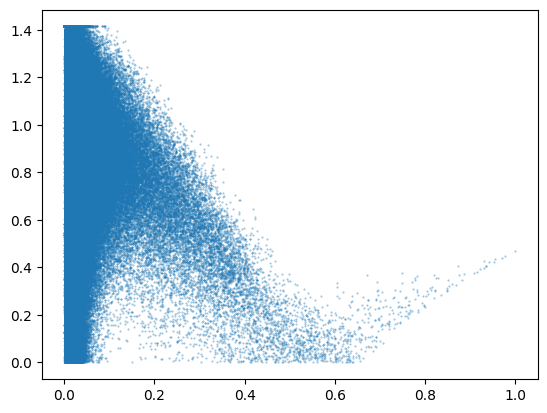

In [ ]:
plt.scatter(*[x for x in[scores_vals, relstds_vals]], s = 0.2, alpha = 0.5)

## Cent Packs

In [84]:
packs = [se.PickleLoad(savefolder + x) for x in ['pack_seq_ohe', 
                                              'pack_yy1_scores', 'pack_yy1_exp', 'pack_yy1_bind',
                                              'pack_his_scores']]

cpacks = [chis.CentTransPack(tp, win, r)
          for tp, win, r in 
          zip(packs, 
              [seq_size, yy1_size, yy1_size, yy1_size, his_size], 
              [1, *([CTreso] * 4)])]

[se.PickleDump(x, savefolder + y) for x,y in zip(cpacks, 
                                              ['cpack_yy1_ohe', 
                                               'cpack_yy1_scores', 'cpack_yy1_exp', 'cpack_yy1_bind', 
                                               'cpack_his_scores'])]

[None, None, None, None, None]

In [85]:
print(bm.BinCount(cpacks[3], uni = np.arange(fin_bins), multi = False))

[17320  1471   458   231   163    76    75    74    81    51]


## TransAug Packs

In [86]:
# We want the centers and the ends. 

packz_names = ['pack_seq_ohe', 
               'pack_yy1_scores', 'pack_yy1_exp', 'pack_yy1_bind',
               'pack_his_scores']

packz_resos, packz_size = [1, *([CTreso] * 5)], [seq_size, yy1_size, yy1_size, yy1_size, his_size, his_size]

for ip, (pn, pr, ps) in enumerate(zip(packz_names, packz_resos, packz_size)): 
    
    packo = se.PickleLoad(savefolder + pn)
    packo = np.swapaxes(packo, -1, -2)

    packo_trans = chis.MakeTransAugs([packo], 
                                     resos = [pr],
                                     slice_size = [ps], 
                                     slice_mode = None,
                                     num_trans = 3)
    
    se.PickleDump(np.swapaxes(packo_trans[0], -1, -2), savefolder + 't' + pn)


(20000, 1, 301, 1, 4, 500)
(20000, 1, 7, 1, 1, 1)
(20000, 1, 7, 1, 2, 1)
(20000, 1, 7, 1, 1, 1)
(20000, 1, 7, 1, 11, 40)


### TRI PACKS

In [87]:
tpackz_names = ['t' + x for x in ['pack_seq_ohe', 
                                  'pack_yy1_scores', 'pack_yy1_exp', 'pack_yy1_bind',
                                  'pack_his_scores']]

tpacks = [se.PickleLoad(savefolder + x) for x in tpackz_names]

tri_tpacks_seq_ohe = np.expand_dims(tpacks[0], axis = 1) 

tri_tpacks = [np.expand_dims(np.swapaxes(x, -1, -2), axis = -1) for x in tpacks[1:]]

tri_tpacks = [tri_tpacks_seq_ohe] + tri_tpacks

se.PickleDump(tri_tpacks, savefolder + 'tri_tpacks')

# Split Gen

Splits are generated by the center pack bind then expanded to include translation augments

In [88]:
fin_bins = se.PickleLoad(savefolder + 'fin_bins')

ascor_args = {'uni': np.arange(fin_bins), 'multi': False, 
              'closest': False, 'reciprocal': True, 'weight_bymem': False,
              'summarize_mode': [se.Epsilon, {}]}

pn_yy1_split = savefolder + 'yy1_split'

aspl_args = ascor_args.copy()
aspl_args.update({'proportions': [0.55, 0.15, 0.15, 0.15], 
                  'num_splits': 1, 'rando': 5000, 'atatime': 100, 
                  'window': True, 'group': None, 'pathname': pn_yy1_split, 
                  'pickup': False})

In [89]:
cpack_yy1_bind = se.PickleLoad(savefolder + 'cpack_yy1_bind')

print(bm.BinCount(cpack_yy1_bind.reshape(-1)))

yy1_split = bm.SplitGen_Akin(cpack_yy1_bind.reshape(-1), **aspl_args)

[17320  1471   458   231   163    76    75    74    81    51]
round 0 of 50
newbest:0.0587978782365484
round 1 of 50
newbest:0.04580017283838461
round 2 of 50
newbest:0.04580017283838461
round 3 of 50
newbest:0.04580017283838461
round 4 of 50
newbest:0.04312596888465025
round 5 of 50
newbest:0.04312596888465025
round 6 of 50
newbest:0.04312596888465025
round 7 of 50
newbest:0.04312596888465025
round 8 of 50
newbest:0.04312596888465025
round 9 of 50
newbest:0.04312596888465025
round 10 of 50
newbest:0.04312596888465025
round 11 of 50
newbest:0.04312596888465025
round 12 of 50
newbest:0.04312596888465025
round 13 of 50
newbest:0.04312596888465025
round 14 of 50
newbest:0.04312596888465025
round 15 of 50
newbest:0.04312596888465025
round 16 of 50
newbest:0.04312596888465025
round 17 of 50
newbest:0.04312596888465025
round 18 of 50
newbest:0.04312596888465025
round 19 of 50
newbest:0.04312596888465025
round 20 of 50
newbest:0.04312596888465025
round 21 of 50
newbest:0.04312596888465025
rou

In [90]:
yy1_split = se.PickleLoad(savefolder + 'yy1_split')
tpack_yy1_bind = se.PickleLoad(savefolder + 'tpack_yy1_bind')

yy1_split_transaug = bm.SplitExpander(1, 3, yy1_split, ma = None)
se.PickleDump(yy1_split_transaug, savefolder + 'yy1_split_transaug')

In [91]:
tpack_yy1_bind = se.PickleLoad(savefolder + 'tpack_yy1_bind')
yy1_split_transaug = se.PickleLoad(savefolder + 'yy1_split_transaug')

#len(tpack_yy1_bind) == np.sum([len(sp) for sp in yy1_split_transaug]) #TRUE 

tots_props = [len(sp) / len(tpack_yy1_bind) for sp in yy1_split_transaug]
bnc_props = [bm.BinCount(tpack_yy1_bind[sp], uni = np.arange(fin_bins), prop = True) for sp in yy1_split_transaug]

d = {'Bin': pd.DataFrame(columns = np.arange(fin_bins), data = bnc_props)}
pdx = pd.concat(d, axis = 1)

pdx['Div.'] = divset
pdx = pdx.set_index(['Div.'])
pdx['Total'] = tots_props

pdx = pdx[['Total', 'Bin']]

pdx = pdx.style.format(precision=4)

minz,maxz = (f(bnc_props, axis = 0) for f in [np.min, np.max])


for im, (mi, ma) in enumerate(zip(minz, maxz)):
    print(im, mi, ma)
    pdx = pdx.background_gradient(cmap = 'Grays', axis = 1, subset = pdx.columns.get_level_values(1) == im,
                                  vmin = mi, vmax = ma)
    
pdx = pdx.background_gradient(cmap = 'Grays', axis = 0, subset = 'Total')

pdx

0 0.9018888888888889 0.9444444444444444
1 0.030222222222222223 0.05188888888888889
2 0.008888888888888889 0.018222222222222223
3 0.006222222222222222 0.010666666666666666
4 0.003777777777777778 0.006333333333333333
5 0.0013333333333333333 0.0030303030303030303
6 0.0013333333333333333 0.0024444444444444444
7 0.0011111111111111111 0.002
8 0.0007777777777777777 0.0026666666666666666
9 0.0006666666666666666 0.0012424242424242424


In [92]:
[bm.BinCount(tpack_yy1_bind[sp], uni = np.arange(fin_bins), prop = False) for sp in yy1_split_transaug]

[array([30206,  1533,   481,   259,   185,   100,    72,    61,    62,
           41]),
 array([8117,  467,  164,   96,   57,   27,   22,   18,   24,    8]),
 array([8500,  272,   80,   59,   34,   15,   17,   10,    7,    6]),
 array([8335,  387,  127,   56,   39,   12,   12,   14,   11,    7])]

## Comparing Holdout Chromosomes

In [9]:
yy1_sites_selo = se.PickleLoad(savefolder + 'yy1_sites_selo')
yy1_sites_selo

,subseq,loc,strand,size,val
0,chr1,820150,0,1,9.170972
1,chr1,821150,0,1,7.072623
2,chr1,827500,0,1,25.289967
3,chr1,904750,0,1,116.017548
4,chr1,913100,0,1,60.970093
...,...,...,...,...,...
49995,chr22,50587950,0,1,3.440850
49996,chr22,50613900,0,1,25.675476
49997,chr22,50623600,0,1,3.314550
49998,chr22,50628350,0,1,17.201210


In [10]:
tpack_yy1_bind = se.PickleLoad(savefolder + 'tpack_yy1_bind')
tpack_yy1_bind = tpack_yy1_bind.reshape(-1)

In [11]:
yy1_flags_chrs = np.tile(yy1_sites_selo['subseq'].to_numpy(), 3) #expand to include the transaugs
 
chrs = np.unique(yy1_flags_chrs)
chrs_order = np.argsort([int(x[3:]) for x in chrs])
chrs = [chrs[x] for x in chrs_order]
print(chrs)

chrs_counts = [np.sum(yy1_flags_chrs == c) for c in chrs]
print(chrs_counts)

chrs_props = [cc / len(yy1_flags_chrs) for cc in chrs_counts]
print(np.round(chrs_props, 4))

chrs_over15 = [chrs[ic] for ic, c in enumerate(chrs_props) if c > 0.1]
print(chrs_over15)

bindoz = [bm.BinCount(tpack_yy1_bind, uni = np.arange(bins), prop = True)]

chrs_binds_props = bindoz + [bm.BinCount(tpack_yy1_bind[yy1_flags_chrs == c],
                             uni = np.arange(bins),                             
                             prop = True) for c in chrs]

d = {'Bin': pd.DataFrame(columns = np.arange(bins), data = chrs_binds_props)}
pdx = pd.concat(d, axis = 1)

pdx['chr'] = ['All'] + [int(x[3:]) for x in chrs]
pdx = pdx.set_index(['chr'])
pdx['Total'] = [1] + chrs_props

pdx = pdx[['Total', 'Bin']]

minz,maxz = (f(chrs_binds_props, axis = 0) for f in [np.min, np.max])

pdx = pdx.style.format(precision=4)

for im, (mi, ma) in enumerate(zip(minz, maxz)):
    pdx = pdx.background_gradient(cmap = 'Grays', axis = 1, subset = pdx.columns.get_level_values(1) == im,
                                  vmin = mi, vmax = ma)


mi_tot, ma_tot = (f(chrs_props + [1]) for f in [np.min, np.max])

pdx = pdx.background_gradient(cmap = 'Grays', axis = 0, subset = 'Total', vmin = mi_tot, vmax = ma_tot)
pdx = pdx.apply(lambda x: ["background: red" if v == 0 else "" for v in x], axis = 1)

pdx

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']
[17841, 10191, 8907, 5829, 7194, 10845, 10062, 5928, 6084, 6441, 7644, 7098, 2814, 3330, 4599, 6063, 7335, 2529, 8190, 4059, 1977, 5040]
[0.1189 0.0679 0.0594 0.0389 0.048  0.0723 0.0671 0.0395 0.0406 0.0429
 0.051  0.0473 0.0188 0.0222 0.0307 0.0404 0.0489 0.0169 0.0546 0.0271
 0.0132 0.0336]
['chr1']


In [18]:
tpack_yy1_bind = se.PickleLoad(savefolder + 'tpack_yy1_bind')
yy1_split_transaug = se.PickleLoad(savefolder + 'yy1_split_transaug')

#len(tpack_yy1_bind) == np.sum([len(sp) for sp in yy1_split_transaug]) #TRUE 

tots_props = [len(sp) / len(tpack_yy1_bind) for sp in yy1_split_transaug]
bnc_props = bindoz + [bm.BinCount(tpack_yy1_bind[sp], uni = np.arange(bins), prop = True) for sp in yy1_split_transaug] 

d = {'Bin': pd.DataFrame(columns = np.arange(bins), data = bnc_props)}
pdx = pd.concat(d, axis = 1)

pdx['Div.'] = ['All'] + divset
pdx = pdx.set_index(['Div.'])
pdx['Total'] = [1] + tots_props

pdx = pdx[['Total', 'Bin']]

pdx = pdx.style.format(precision=4)

# for im, (mi, ma) in enumerate(zip(minz, maxz)):
#     print(im, mi, ma)
#     pdx = pdx.background_gradient(cmap = 'Grays', axis = 1, subset = pdx.columns.get_level_values(1) == im,
#                                   vmin = mi, vmax = ma)
    
pdx = pdx.background_gradient(cmap = 'Grays', axis = 0) #, subset = 'Total', vmin = mi_tot, vmax = ma_tot)

pdx

# Extra Analysis

In [7]:
tpack_yy1_exp = se.PickleLoad(savefolder + 'tpack_yy1_exp')

In [ ]:
import scipy

replix = 10
psu = 1e-10

tpack_yy1_exp = se.PickleLoad(savefolder + 'tpack_yy1_exp')

yy1_score, conto_score = [tpack_yy1_exp[:, :, x] for x in [0, 1]]

yy1_rep = np.array([[np.mean(scipy.stats.gamma.rvs(der + psu, size = 3)) for _ in np.arange(replix)] for der in yy1_score])
conto_rep = np.array([[np.mean(scipy.stats.gamma.rvs(der + psu, size = 3)) for _ in np.arange(replix)] for der in conto_score])

<Axes: xlabel='YY1 Score', ylabel='Simulated Standard Deviation'>

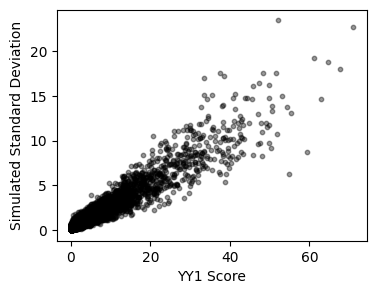

In [31]:
import ocu_trident.ocu_tri_utils as tu

tpack_yy1_scores = se.PickleLoad(savefolder + 'tpack_yy1_scores')
yy1_max = se.PickleLoad(savefolder + 'yy1_max')

yy1cs = tu.BetaPrime_Mode(yy1_rep, conto_rep)

yy1cs_mean = np.mean(yy1cs, axis = -1)
yy1cs_std = np.std(yy1cs, axis = -1) 

viz.ScaPlot([tpack_yy1_scores.reshape(-1) * yy1_max, yy1cs_std], 
            xlabel = 'YY1 Score', ylabel = 'Simulated Standard Deviation',
            boundspad = 0.05,  
            figsize = (4, 3), color = 'Black', alpha = 0.4)

In [17]:
yy1cs.shape

(60000, 10)

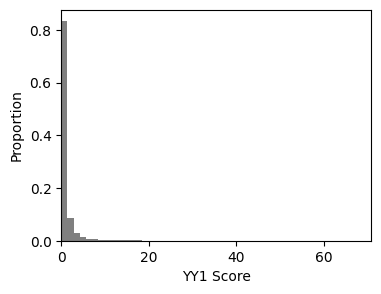

In [33]:
tpack_yy1_scores = se.PickleLoad(savefolder + 'tpack_yy1_scores')

hp_args = {'bins': 50, 'density': False,'proportion': True, 
           'xlabel': 'YY1 Score', 'ylabel': 'Proportion', 'color': 'black'}

viz.HistPlot(tpack_yy1_scores.reshape(-1) * yy1_max, **hp_args, figsize = (4, 3))

In [26]:
yy1_weights = tpack_yy1_scores.reshape(-1) / tpack_yy1_scores.sum()

In [16]:
tpack_his_scores = se.PickleLoad(savefolder + 'tpack_his_scores')

<Axes: xlabel='Mean YY1 Score', ylabel='Std. YY1 Score'>

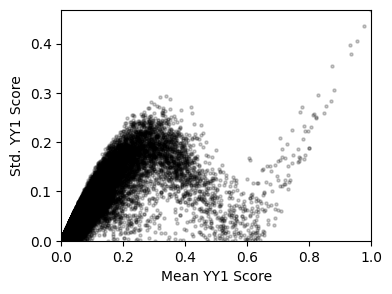

In [11]:
# tri_tpacks = se.PickleLoad(savefolder + 'tri_tpacks')

dx1, dy1, dy1S, db, dx2, dx2S = tri_tpacks

sca_args = {'pointsize': 5, 'alpha': 0.2, 
           'xlabel': 'Mean YY1 Score', 'ylabel': 'Std. YY1 Score', 'color': 'black', 
           'figsize': (4,3)}

viz.ScaPlot([dy1 ,dy1S], **sca_args)

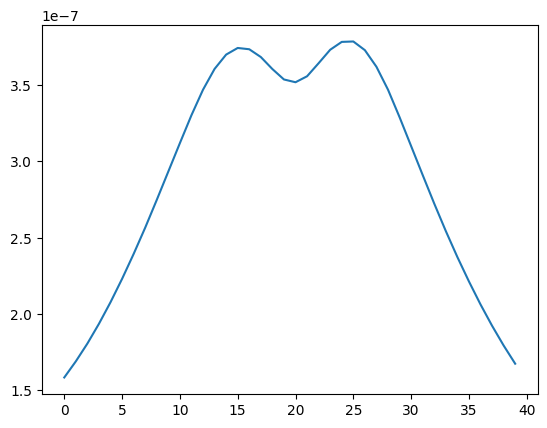

In [29]:
hissamp = tpack_his_scores[:, :, 1] 
hissamp_wei = hissamp * yy1_weights.reshape(-1, 1)
hissamp_mean = hissamp_wei.mean(axis = 0)
plt.plot(hissamp_mean)

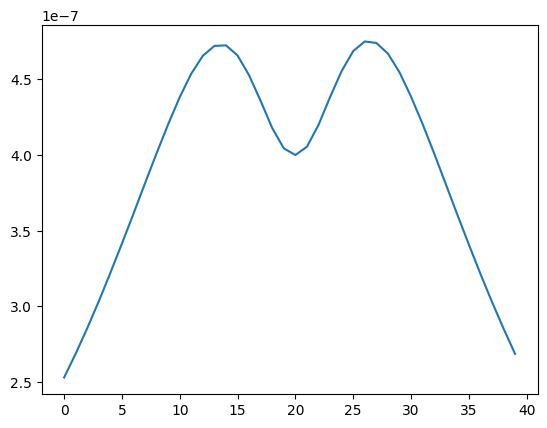

In [30]:
hissamp = tpack_his_scores[:, :, 6] 
hissamp_wei = hissamp * yy1_weights.reshape(-1, 1)
hissamp_mean = hissamp_wei.mean(axis = 0)
plt.plot(hissamp_mean)

In [ ]:
hisos = tpack_his_scores.reshape(-1, 11).T

In [39]:
hisos = tpack_his_scores.reshape(-1, 11).T

for ih1, h1 in enumerate(histones): 
    for ih2, h2 in enumerate(histones): 
        if h1 != h2: 
            cor = Correlation(hisos[ih1], hisos[ih2]) ** 2
            if cor > 0.7 or cor < -0.7 : print(f'{h1, h2, cor}')

('H3K4me3', 'H3K9ac', 0.795479158943969)
('H3K4me3', 'H3K4me2', 0.8790883544664659)
('H3K27ac', 'H3K9ac', 0.7842835828460811)
('H3K9ac', 'H3K4me3', 0.795479158943969)
('H3K9ac', 'H3K27ac', 0.7842835828460811)
('H3K4me2', 'H3K4me3', 0.8790883544664662)
